## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [153]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


# Analyze Dataset

In [3]:
train_data.shape

(84534, 10)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [154]:
# remodel promotion field to binary
train_data.Promotion = train_data.Promotion.map({'No':0, 'Yes':1})

In [8]:
# check features cardinality...
for i in [1,4,5,6,7]:
    print(f'V{i}:',train_data[f'V{i}'].unique())

V1: [2 3 0 1]
V4: [1 2]
V5: [1 3 4 2]
V6: [3 2 4 1]
V7: [2 1]


In [9]:
# ... and proportions
for i in [1,4,5,6,7]:
    print(f'V{i}:')
    print(train_data[f'V{i}'].value_counts(normalize=True))

V1:
1    0.374181
2    0.373909
3    0.126221
0    0.125689
Name: V1, dtype: float64
V4:
2    0.679608
1    0.320392
Name: V4, dtype: float64
V5:
3    0.387335
2    0.369035
1    0.182317
4    0.061313
Name: V5, dtype: float64
V6:
3    0.250621
4    0.250503
2    0.250148
1    0.248728
Name: V6, dtype: float64
V7:
2    0.701694
1    0.298306
Name: V7, dtype: float64


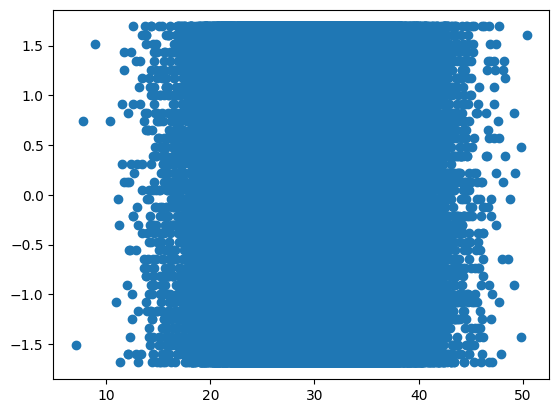

In [64]:
# visualize V2 and V4
plt.scatter(x=train_data.V2, y=train_data.V3)

<AxesSubplot:>

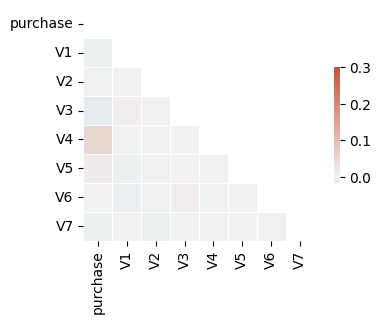

In [10]:
# Check correlations
# Select users with promotion and remove Id
corr = train_data[train_data.Promotion==1].iloc[:,2:].corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

==> we see correlation between purchase and V4

<AxesSubplot:>

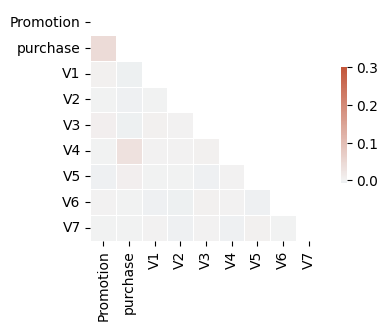

In [11]:
# Check correlations
# remove Id
corr = train_data.iloc[:,1:].corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

==> we see correlation between promotion and purchase and V4 and purchase

# STATISTICAL TESTS

In [155]:
control = train_data[train_data.Promotion==0]
experiment = train_data[train_data.Promotion==1]

- Let's check our invariant metric. The number of users should be equivalent between the 2 groups (with promotion, without)

In [156]:
# invariant metric
print('Number of users in each group =',len(control), len(experiment))

Number of users in each group = 42170 42364


In [157]:
obs_ratio =  len(experiment)/len(train_data)
print('observed ratio between the groups', obs_ratio)

observed ratio between the groups 0.5011474672912675


### Invariant hypothesis testing
- H0: ratio = 0.5
- H1: ratio != 0.5

- we are looking for a type 1 error of 5% (level of significance)

In [158]:
alpha = 0.05

In [159]:
# sampling
ratios = []
for _ in range(1000):
    sample = train_data.sample(len(train_data), replace=True)
    ratio = len(sample[sample.Promotion==1])/len(sample)
    ratios.append(ratio)

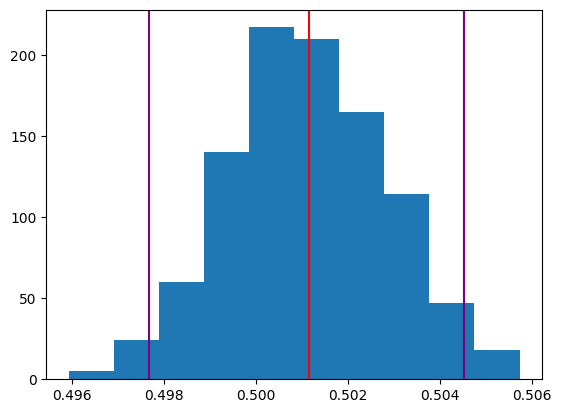

In [160]:
# Our 95% boostrap interval of confidence
upper_bound = np.quantile(ratios, 1 - alpha/2)
lower_bound = np.quantile(ratios, alpha/2)
plt.hist(ratios)
plt.axvline(obs_ratio, c='r')
plt.axvline(upper_bound, c='purple')
plt.axvline(lower_bound, c='purple')

The upper and lower boundaries from our sampling distribution determine the confidence interval for our population parameter. We can be 95% confident that the population mean ratio falls between these boundaries.

In [161]:
# sampling assuming H0 is True - the distribution is centered on 0.5
null_dist = np.random.normal(0.5, np.std(ratios), size=len(ratios))
null_upper_bound = np.quantile(null_dist, 1 - alpha/2)
null_lower_bound = np.quantile(null_dist, alpha/2)

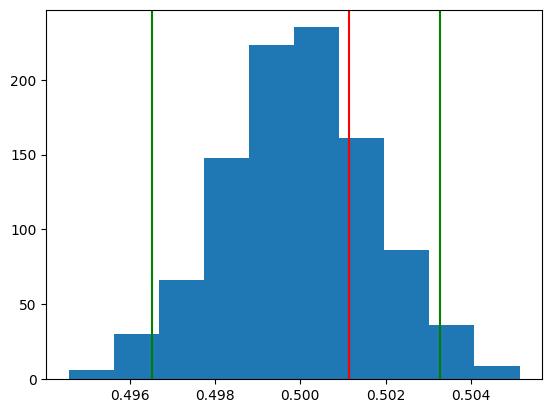

In [163]:

plt.hist(null_dist)
plt.axvline(obs_ratio, c='r')
plt.axvline(null_upper_bound, c='green')
plt.axvline(null_lower_bound, c='green')

In [48]:
p_value = (null_dist > obs_ratio).mean() + (null_dist < 0.5 + (0.5 - obs_ratio)).mean()
p_value

0.502

CONCLUSION INVARIANT TEST:
- p-value is well above our significance level. 
- our sample mean falls within the 95% interval using significance level threshold

=> We fail to reject H0 - the size of the two groups are statistically identical (no statistical significance)

### IRR Evaluation metric hypothesis testing
- IRR is the difference between the proportion of users making a purchase between the 2 groups
- H0: IRR <=0  - The experiment did not improve the purchase rate
- H1: IRR > 0

- Significance Level and Type 1 error threshold: since we evaluate using 2 metrics (IRR and NIR), we will apply Bonferroni correction to maintain error rate

In [164]:
alpha = 0.05
alpha_corrected = alpha / 2
alpha_corrected

0.025

In [165]:
obs_irr = len(experiment[experiment.purchase==1])/len(experiment) - len(control[control.purchase==1])/len(control)
print('Observed difference', obs_irr)
print(f'we see a small improvement of purchase rate of {obs_irr:.2%}')

Observed difference 0.009454547819772702
we see a small improvement of purchase rate of 0.95%


In [166]:
# sampling
diffs = []
for _ in range(10_000):
    sample = train_data.sample(len(train_data), replace=True)
    control_g = sample[sample.Promotion==0]
    experiment_g = sample[sample.Promotion==1]
    diff = len(experiment_g[experiment_g.purchase==1])/len(experiment_g) - len(control_g[control_g.purchase==1])/len(control_g)
    diffs.append(diff)

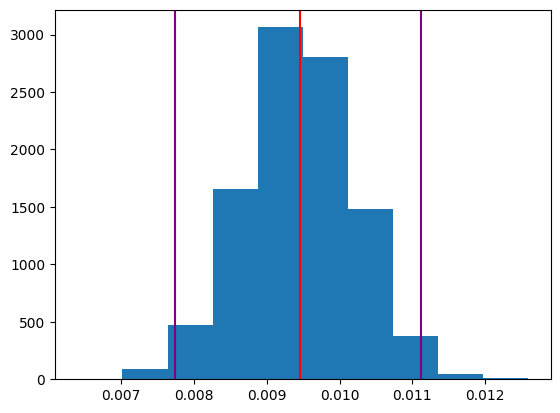

In [167]:
# Our 95% boostrap interval of confidence
upper_bound = np.quantile(diffs, 1 - alpha_corrected/2)
lower_bound = np.quantile(diffs, alpha_corrected/2)
plt.hist(diffs)
plt.axvline(obs_irr, c='r')
plt.axvline(upper_bound, c='purple')
plt.axvline(lower_bound, c='purple')

In [168]:
# sampling assuming H0
null_dist = np.random.normal(0, np.std(diffs), size=len(diffs))
null_upper_bound = np.quantile(null_dist, 1 - alpha_corrected/2)
null_lower_bound = np.quantile(null_dist, alpha_corrected/2)

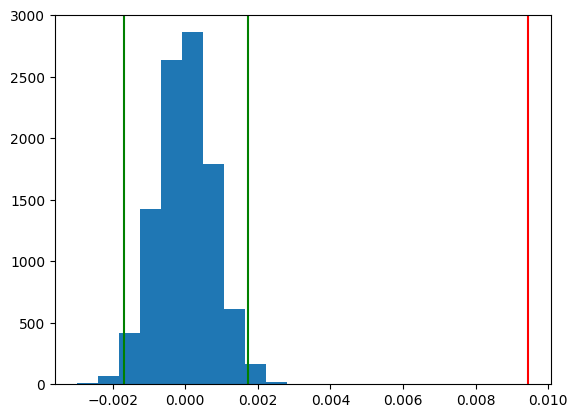

In [170]:
plt.hist(null_dist)
plt.axvline(obs_irr, c='r')
plt.axvline(null_upper_bound, c='green')
plt.axvline(null_lower_bound, c='green')

In [53]:
# This is a one sided test absed on H1 > 0
p_value = (null_dist > obs_irr).mean()
p_value

0.0

CONCLUSION IRR EVALUATION METRIC
- we see that our sample mean is way outside the 95% significance level under the Null hypothesis
- our p-value is below our corrected significance level alpha
- The 95% confidence interval from our sampling distribution (purple boundaries) excludes the null hypothesis value of 0.
- We REJECT H0 - Based on our sample, the difference in purchase rate is statistically significant between no promotion and promotion groups

### NIR Evaluation metric hypothesis testing
- NIR is the incremental revenue generated by the purchasing group having received a promotion net of the promotion cost
- H0: NIR <=0  - The experiment did not generate extra revenue
- H1: NIR > 0

In [171]:
observed_NIR = 10 * len(experiment[experiment.purchase==1]) - 0.15 * len(experiment) - 10 * len(control[control.purchase==1])
print('Observed NIR is ', observed_NIR)
print('It seems the promotion costs more than the incremental revenue generated')


Observed NIR is  -2334.5999999999995
It seems the promotion costs more than the incremental revenue generated


In [172]:
# sampling
nirs = []
for _ in range(10_000):
    sample = train_data.sample(len(train_data), replace=True)  # take 20% of the sample size
    control_g = sample[sample.Promotion==0]
    experiment_g = sample[sample.Promotion==1]
    nir = 10 * len(experiment_g[experiment_g.purchase==1]) - 0.15 * len(experiment_g) - 10 * len(control_g[control_g.purchase==1])
    nirs.append(nir)

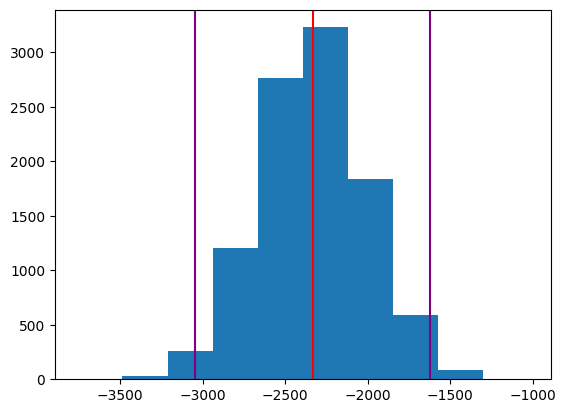

In [173]:
# Our 95% boostrap interval of confidence
upper_bound = np.quantile(nirs, 1 - alpha_corrected/2)
lower_bound = np.quantile(nirs, alpha_corrected/2)
plt.hist(nirs)
plt.axvline(observed_NIR, c='r')
plt.axvline(upper_bound, c='purple')
plt.axvline(lower_bound, c='purple')

In [174]:
# sampling assuming H0
null_dist = np.random.normal(0, np.std(nirs), size=len(nirs))
null_upper_bound = np.quantile(null_dist, 1 - alpha_corrected/2)
null_lower_bound = np.quantile(null_dist, alpha_corrected/2)

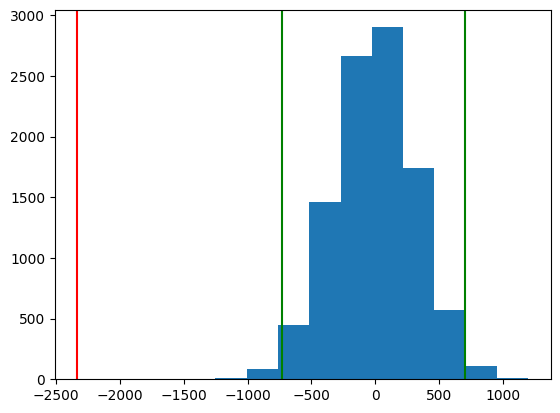

In [175]:
plt.hist(null_dist)
plt.axvline(observed_NIR, c='r')
plt.axvline(null_upper_bound, c='green')
plt.axvline(null_lower_bound, c='green')

In [176]:
# We do Bonferroni correction with 2 metrics and will compare p-value to alpha / 2
p_value = (null_dist > observed_NIR).mean()
p_value

1.0

CONCLUSION NIR EVALUATION METRIC
- we see that our sample mean is outside the 95% significance level boundaries from Normal distribution under NULL hypothesis
- our p-value is above our corrected significance level alpha
- We FAIL to reject H0 - The incremental revenue between no promotion and promotion groups from the experiment sample is not statistically significant

### Alternative calculation using a 20% fraction of the sample

In [177]:
# sampling
nirs = []
sample_size = int(len(train_data)*0.2)
for _ in range(10_000):
    sample = train_data.sample(sample_size, replace=True)  # take 20% of the sample size
    control_g = sample[sample.Promotion==0]
    experiment_g = sample[sample.Promotion==1]
    nir = 10 * len(experiment_g[experiment_g.purchase==1]) - 0.15 * len(experiment_g) - 10 * len(control_g[control_g.purchase==1])
    nirs.append(nir)

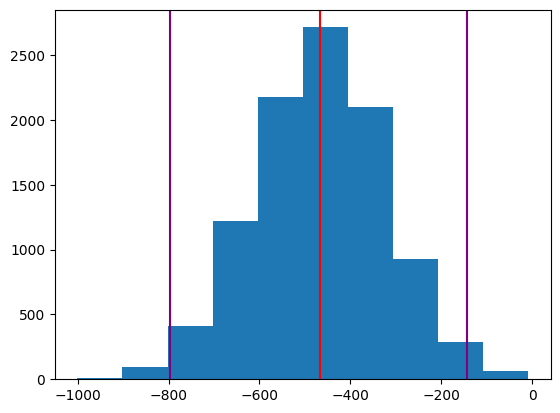

In [178]:
# Our 95% interval of confidence
upper_bound = np.quantile(nirs, 1 - alpha_corrected/2)
lower_bound = np.quantile(nirs, alpha_corrected/2)
plt.hist(nirs)
plt.axvline(observed_NIR * 0.2, c='r')
plt.axvline(upper_bound, c='purple')
plt.axvline(lower_bound, c='purple')

In [179]:
#sampling H0
null_dist = np.random.normal(0, np.std(nirs), size=len(nirs))
null_upper_bound = np.quantile(null_dist, 1 - alpha_corrected/2)
null_lower_bound = np.quantile(null_dist, alpha_corrected/2)

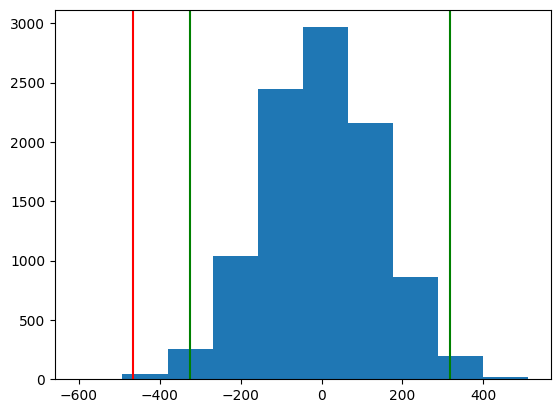

In [180]:
plt.hist(null_dist)
plt.axvline(observed_NIR * 0.2, c='r')
plt.axvline(null_upper_bound, c='green')
plt.axvline(null_lower_bound, c='green')

In [181]:
# We do Bonferroni correction with 2 metrics and will compare p-value to alpha / 2
p_value = (null_dist > observed_NIR * sample_size/train_data.shape[0]).mean()
p_value

0.9994

=> We FAIL to REJECT H0

# MODELING to OPTIMIZE PROMOTION TARGET SAMPLE
- we established that the promotion has a positive impact on purchase rate
- But the promotion seems to reach a too large target compared to response - Practical significance is not satisfied
- the objective now is to improve the target to receive the promotion and optimize the NIR to recover the promotion costs

In [182]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [183]:
train_data

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,0,0,2,30.443518,-1.165083,1,1,3,2
1,3,0,0,3,32.159350,-0.645617,2,3,2,2
2,4,0,0,2,30.431659,0.133583,1,1,4,2
3,5,0,0,0,26.588914,-0.212728,2,1,4,2
4,8,1,0,3,28.044331,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...
84529,126180,0,0,1,30.084876,1.345672,1,1,3,1
84530,126181,1,0,3,33.501485,-0.299306,1,1,4,1
84531,126182,0,0,1,31.492019,1.085939,2,3,2,2
84532,126183,0,0,1,37.766106,0.999361,2,2,1,2


In [184]:
# Let's build a classification model using XGboost
xgb = XGBClassifier()
X = train_data.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [186]:
# make predictions on test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 98.77%
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16699
           1       0.00      0.00      0.00       208

    accuracy                           0.99     16907
   macro avg       0.49      0.50      0.50     16907
weighted avg       0.98      0.99      0.98     16907



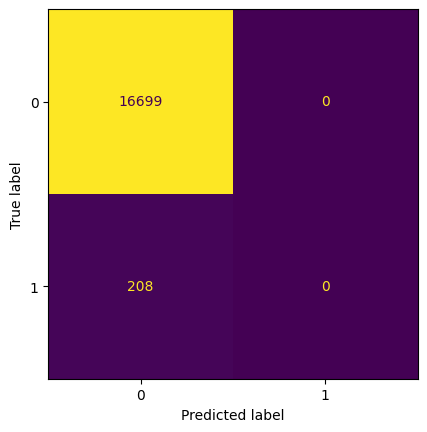

In [187]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, colorbar=False)

We have a poor F1 score due to class imbalance. Only 1% of the data made a purchase

In [90]:
Y.value_counts(normalize=True)

0    0.987697
1    0.012303
Name: purchase, dtype: float64

- Let's apply a correction

In [188]:
xgb = XGBClassifier(scale_pos_weight=(Y==0).sum()/(Y==1).sum())
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [189]:
# make predictions on test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 88.31%
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     16699
           1       0.02      0.13      0.03       208

    accuracy                           0.88     16907
   macro avg       0.50      0.51      0.48     16907
weighted avg       0.98      0.88      0.93     16907



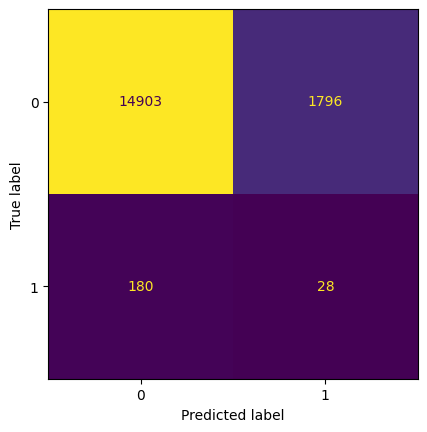

In [190]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, colorbar=False)

this is still very unsatisfactory

- Let's oversample the purchasing set (highly under-represented class)

In [191]:
purchase_set = train_data[train_data.purchase==1]
no_purchase_set = train_data[train_data.purchase==0]
len(purchase_set), len(no_purchase_set)

(1040, 83494)

In [192]:
# we target a 3/8 5/8 ratio
purchase_sample = purchase_set.sample(30_000, replace=True)
no_purchase_sample = no_purchase_set.sample(50_000, replace=False)

In [193]:
dataset = pd.concat([purchase_sample,no_purchase_sample])
dataset

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
43098,64083,0,1,2,28.764269,-1.078506,2,2,4,2
43678,64937,1,1,0,27.215956,1.518828,2,3,4,2
35476,52802,0,1,2,28.519699,0.479895,2,1,2,1
75479,112664,1,1,1,33.143970,-0.472461,2,2,4,2
35775,53259,1,1,0,25.576515,-0.299306,2,2,3,2
...,...,...,...,...,...,...,...,...,...,...
3063,4530,0,0,1,38.643900,-1.511395,2,2,2,2
83786,125050,0,0,2,31.987225,-1.338239,2,3,3,1
39444,58633,1,0,1,35.318618,0.047006,2,2,2,2
27543,40906,0,0,1,28.926837,0.912784,2,3,2,2


In [194]:
# Let's build a classification model using XGboost
xgb = XGBClassifier()
X = dataset.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable

In [195]:
Y.value_counts(normalize=True)

0    0.625
1    0.375
Name: purchase, dtype: float64

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [197]:
# make predictions on test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 90.83%
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     10000
           1       0.90      0.85      0.87      6000

    accuracy                           0.91     16000
   macro avg       0.91      0.90      0.90     16000
weighted avg       0.91      0.91      0.91     16000



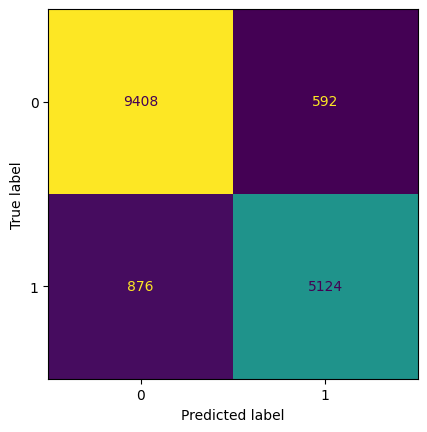

In [198]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, colorbar=False)

Our model achieves a strong accuracy and strong F1 score on both classes

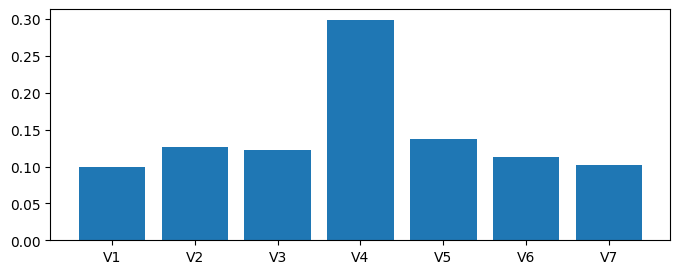

In [199]:
# plot feature importances
fig,ax = plt.subplots()
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.xticks(range(len(xgb.feature_importances_)), labels=X_train.columns.tolist())
fig.set_figwidth(8)
fig.set_figheight(3)
plt.show()

# Promotion Strategy

In [147]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    y_pred = model.predict(df)

    promotion =  np.array(['Yes' if x==1 else 'No' for x in y_pred])
    
    return promotion

In [148]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice
model= xgb
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0160.

Your nir with this strategy is 5.80.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01595531308917325, 5.800000000000011)

#### Let's see if we can do better using alternative model on original data

In [200]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=10, class_weight='balanced_subsample')
X = train_data.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)

In [201]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       random_state=10)

In [202]:
# make predictions on test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 58.40%
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.74     16699
           1       0.02      0.56      0.03       208

    accuracy                           0.58     16907
   macro avg       0.50      0.57      0.38     16907
weighted avg       0.98      0.58      0.73     16907



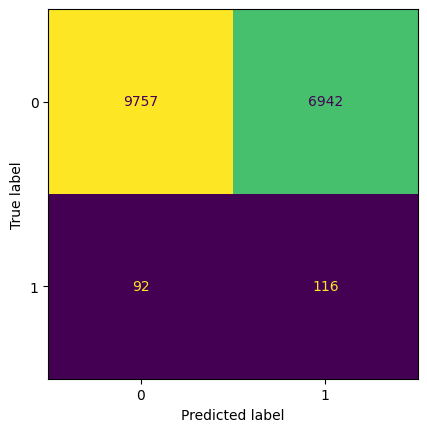

In [203]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False)

this is not bad considering we use the original highly imbalanced dataset

In [205]:
model= clf
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0199.

Your nir with this strategy is 411.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019884488395896772, 411.25)

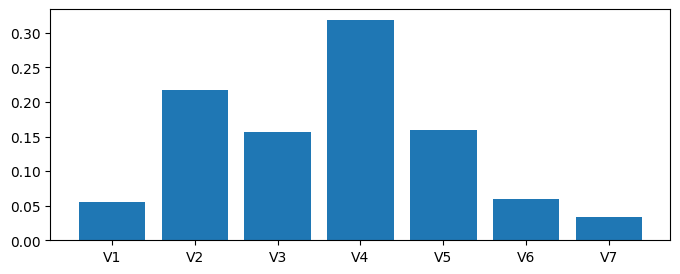

In [204]:
# plot feature importances
fig,ax = plt.subplots()
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.xticks(range(len(clf.feature_importances_)), labels=X_train.columns.tolist())
fig.set_figwidth(8)
fig.set_figheight(3)
plt.show()

Let's now apply to our oversampled dataset

In [269]:
clf = RandomForestClassifier(max_depth=5, random_state=10, class_weight='balanced_subsample')
X = dataset.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)

In [270]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       random_state=10)

In [271]:
# make predictions on test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 60.46%
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.55      0.63     10000
           1       0.48      0.70      0.57      6000

    accuracy                           0.60     16000
   macro avg       0.62      0.62      0.60     16000
weighted avg       0.65      0.60      0.61     16000



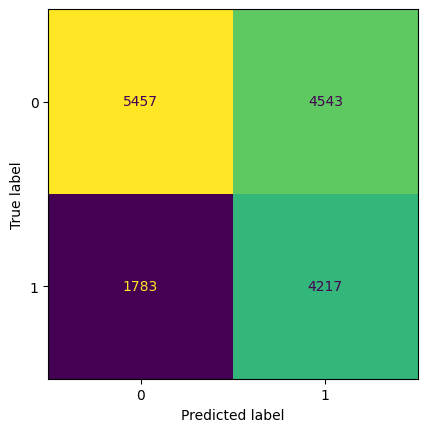

In [272]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False)

this looks better although we do have large false positives

In [273]:
model= clf
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0197.

Your nir with this strategy is 429.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019713036356358724, 429.4000000000001)

This shows a slight improvement in NIR metric

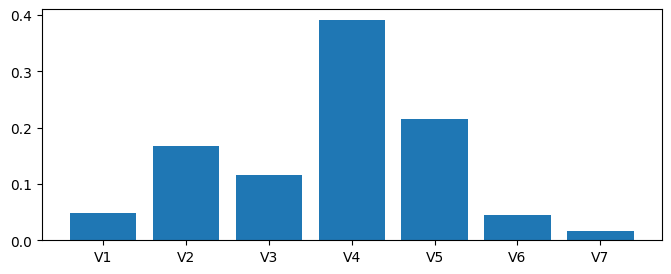

In [274]:
# plot feature importances
fig,ax = plt.subplots()
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.xticks(range(len(clf.feature_importances_)), labels=X_train.columns.tolist())
fig.set_figwidth(8)
fig.set_figheight(3)
plt.show()

# Using imbalanced-learn module
- Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.

Let's compare RandomForest

In [213]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [253]:
brf = BalancedRandomForestClassifier(max_depth=5, n_estimators= 100, replacement=True, random_state=10)
X = train_data.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=5, random_state=10, replacement=True)

In [254]:
# make predictions on test data
y_pred = brf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 51.47%
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.51      0.68     16699
           1       0.02      0.62      0.03       208

    accuracy                           0.51     16907
   macro avg       0.50      0.57      0.35     16907
weighted avg       0.98      0.51      0.67     16907



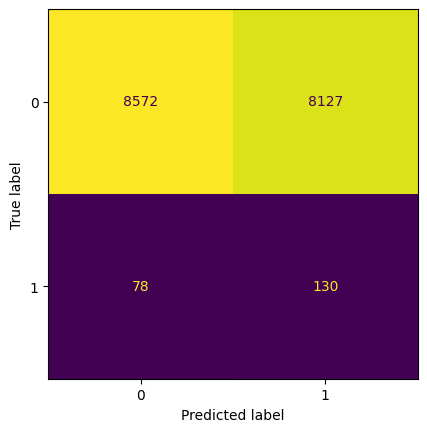

In [255]:
ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, colorbar=False)

In [256]:
model= brf
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0187.

Your nir with this strategy is 368.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018672364465667578, 368.95000000000005)

Actually worse. What if using our oversampled dataset?

In [257]:
X = dataset.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)

In [258]:
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=5, random_state=10, replacement=True)

In [259]:
# make predictions on test data
y_pred = brf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 61.36%
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65     10000
           1       0.49      0.70      0.57      6000

    accuracy                           0.61     16000
   macro avg       0.62      0.63      0.61     16000
weighted avg       0.66      0.61      0.62     16000



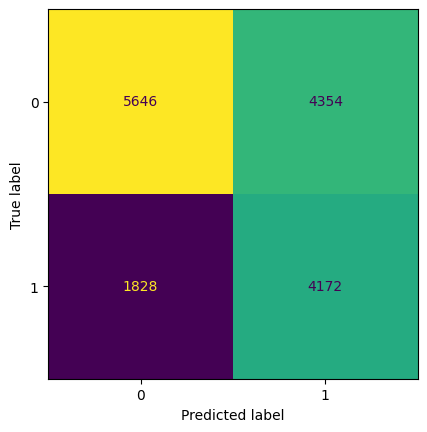

In [260]:
ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, colorbar=False)

How impressive !

In [261]:
model= brf
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0196.

Your nir with this strategy is 405.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01957486535080664, 405.1500000000001)

Very close to our best results

Let's try a boosting classifier

In [265]:
from imblearn.ensemble import EasyEnsembleClassifier

#estimator = AdaBoostClassifier(n_estimators=10)
eec = EasyEnsembleClassifier(sampling_strategy='auto', replacement=True, n_estimators=10) #estimator=estimator
X = train_data.iloc[:,2:]   # we drop ID and Promotion and only keep the V features
Y = X.pop('purchase')       # 'Purchase' is our target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
eec.fit(X_train, y_train)


EasyEnsembleClassifier(replacement=True)

In [266]:
# make predictions on test data
y_pred = eec.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

Accuracy: 49.99%
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     16699
           1       0.02      0.63      0.03       208

    accuracy                           0.50     16907
   macro avg       0.50      0.57      0.35     16907
weighted avg       0.98      0.50      0.66     16907



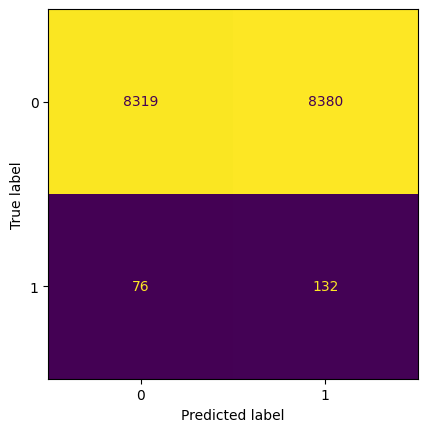

In [267]:
ConfusionMatrixDisplay.from_estimator(eec, X_test, y_test, colorbar=False)

In [268]:
model= eec
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0182.

Your nir with this strategy is 322.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018197665694344306, 322.4000000000001)

CONCLUSION
- best results on NIR achieved by qualifying promotion target group using ML model based on RandomForest
- Training taking highly imbalanced training set into account
- Selecting the customers based on their profile increases importantly the effect of sending out promotions
- Those customers show importance of V4, V2 and V5, V3 features in the purchase response to promotion